In [4]:
# !pip install timm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
import numpy as np
from tqdm import tqdm
import os
from sklearn.metrics import classification_report

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "/kaggle/input/skin-cancer-balance-augmented/augmented_images_balance/"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

print(f"training set: {len(train_dataset)}")
print(f"validation set: {len(val_dataset)}")
print(f"test set: {len(test_dataset)}")


training set: 18124
validation set: 1502
test set: 1503


In [7]:

model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=len(train_dataset.classes))

state_dict = torch.load("/kaggle/input/vit/pytorch/default/1/pytorch_model.bin", map_location=device, weights_only=True)

filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("head.")}

model.load_state_dict(filtered_state_dict, strict=False)

num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)

model = model.to(device)


In [8]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [9]:
# Loss function and optimizer

class_weights = torch.tensor([0.8030840127614322, 1.3248538011695907], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

# Early stopping parameters
patience = 3
best_val_loss = np.inf
early_stop_counter = 0
num_epochs = 20

# Training loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", ncols=100):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Adjust learning rate
    scheduler.step(avg_val_loss)

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")  # Save best model
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

print("Training complete. Best model saved at '/kaggle/working/best_model.pth'.")


Epoch 1/20: 100%|█████████████████████████████████████████████████| 567/567 [05:41<00:00,  1.66it/s]


Epoch [1/20], Loss: 0.5262, Train Acc: 70.39%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.92it/s]


Validation Loss: 0.4101, Validation Accuracy: 79.09%


Epoch 2/20: 100%|█████████████████████████████████████████████████| 567/567 [05:40<00:00,  1.66it/s]


Epoch [2/20], Loss: 0.4085, Train Acc: 79.43%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.96it/s]


Validation Loss: 0.3734, Validation Accuracy: 82.42%


Epoch 3/20: 100%|█████████████████████████████████████████████████| 567/567 [05:41<00:00,  1.66it/s]


Epoch [3/20], Loss: 0.3613, Train Acc: 82.67%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.96it/s]


Validation Loss: 0.3097, Validation Accuracy: 84.95%


Epoch 4/20: 100%|█████████████████████████████████████████████████| 567/567 [05:41<00:00,  1.66it/s]


Epoch [4/20], Loss: 0.3171, Train Acc: 85.36%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.96it/s]


Validation Loss: 0.3585, Validation Accuracy: 83.42%
Early stopping counter: 1/3


Epoch 5/20: 100%|█████████████████████████████████████████████████| 567/567 [05:40<00:00,  1.66it/s]


Epoch [5/20], Loss: 0.2765, Train Acc: 87.58%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.96it/s]


Validation Loss: 0.3623, Validation Accuracy: 83.82%
Early stopping counter: 2/3


Epoch 6/20: 100%|█████████████████████████████████████████████████| 567/567 [05:41<00:00,  1.66it/s]


Epoch [6/20], Loss: 0.2399, Train Acc: 89.54%


Validation: 100%|███████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.97it/s]

Validation Loss: 0.3592, Validation Accuracy: 84.89%
Early stopping counter: 3/3
Early stopping triggered. Stopping training.
Training complete. Best model saved at '/kaggle/working/best_model.pth'.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

correct, total = 0, 0

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Evaluation", ncols=100):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Evaluation: 100%|██████████████████████████████████████████████| 47/47 [00:09<00:00,  4.87it/s]

Test Accuracy: 83.23%


In [12]:
# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) 

# Print classification report
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1210
           1       0.55      0.78      0.64       293

    accuracy                           0.83      1503
   macro avg       0.74      0.81      0.77      1503
weighted avg       0.86      0.83      0.84      1503



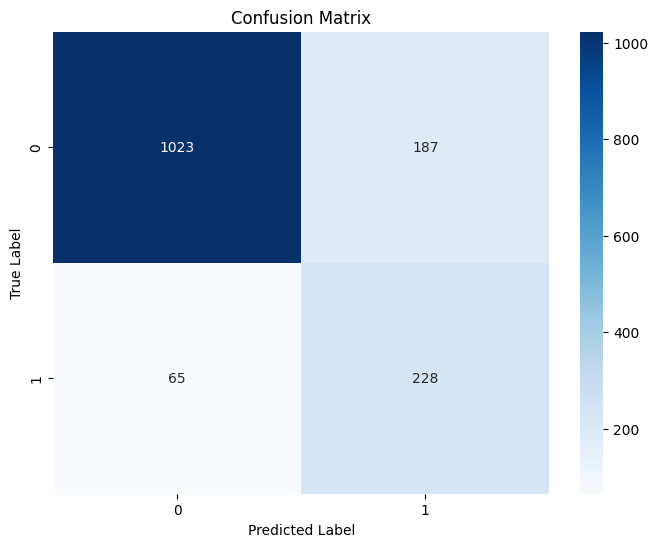

In [15]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ROC AUC: 0.9071


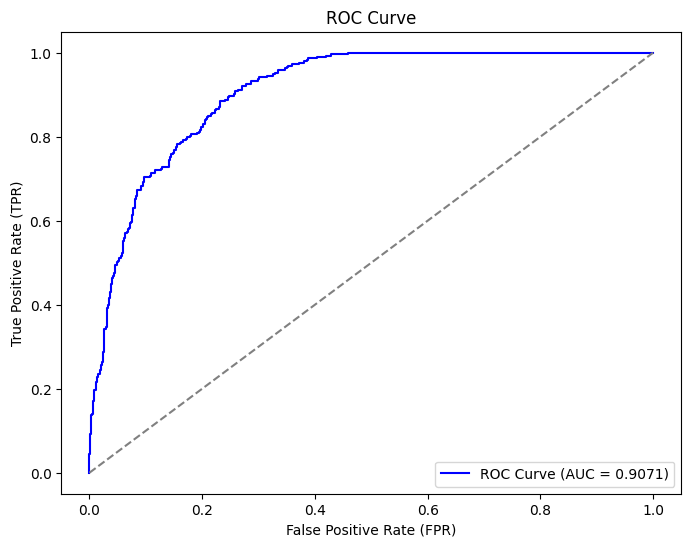

In [14]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
model.eval()

all_preds_prob = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        if outputs.shape[1] == 1: 
            probs = torch.sigmoid(outputs).squeeze(1)
        else:
            probs = F.softmax(outputs, dim=1)[:, 1] 

        all_preds_prob.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

roc_auc = roc_auc_score(all_labels, all_preds_prob)
print(f"ROC AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
